# Predicting points for fantasy defense
This notebook will complete the predictive model for FanDuel and DraftKings points for team defenses.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nfl_data_py as nfl

In [2]:
import sqlite3

# Connecting to the database
We import sqlite3 and connect to our database to retrieve our defense_df dataframe, which we used to derive the target variable for our defense model and will use again to extract some features, and also our defense_target dataframe, which contains the target variable for all team defenses.

In [3]:
# Connect to the SQLite database
conn = sqlite3.connect('nfl_dfs.db')

# Query specific columns from the table
query1 = "SELECT * FROM team_defense"
defense_df = pd.read_sql_query(query1, conn)

query2 = "SELECT * FROM defense_target"
defense_target = pd.read_sql_query(query2, conn)

# Close the connection
conn.close()

In [4]:
defense_df.head()

,id,Unnamed: 0,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,...,div_game,roof,surface,pass,rush,posteam_score,posteam_score_post,defteam_score,defteam_score_post,desc
0,0,0,34.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,...,1,outdoors,grass,0.0,0.0,NaN,0.0,NaN,0.0,B.Daluiso kicks 72 yards from NYG 30 to ARI -2...
1,1,1,70.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,...,1,outdoors,grass,0.0,0.0,0.0,0.0,0.0,0.0,B.Daluiso kicks 69 yards from NYG 25 to ARI 6....
2,2,2,106.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,...,1,outdoors,grass,0.0,1.0,0.0,0.0,0.0,0.0,(15:00) T.Jones left end to ARI 37 for 2 yards...
3,3,3,131.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,...,1,outdoors,grass,1.0,0.0,0.0,0.0,0.0,0.0,(14:04) J.Plummer pass incomplete to T.Jones.
4,4,4,148.0,2000_01_ARI_NYG,2000090300,NYG,ARI,REG,1,ARI,...,1,outdoors,grass,1.0,0.0,0.0,0.0,0.0,0.0,(13:57) (Shotgun) J.Plummer pass incomplete to...


In [5]:
defense_target.head()

,season,week,game_id,defteam,FD_Pts,DK_Pts
0,2000,1,2000_01_ARI_NYG,ARI,4.0,4.0
1,2000,1,2000_01_ARI_NYG,NYG,10.0,10.0
2,2000,1,2000_01_BAL_PIT,BAL,13.0,13.0
3,2000,1,2000_01_BAL_PIT,PIT,2.0,2.0
4,2000,1,2000_01_CAR_WAS,CAR,7.0,7.0


In [6]:
defense_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1135207 entries, 0 to 1135206
Data columns (total 67 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   id                             1135207 non-null  int64  
 1   Unnamed: 0                     1135207 non-null  int64  
 2   play_id                        1135207 non-null  float64
 3   game_id                        1135207 non-null  object 
 4   old_game_id                    1135207 non-null  int64  
 5   home_team                      1135207 non-null  object 
 6   away_team                      1135207 non-null  object 
 7   season_type                    1135207 non-null  object 
 8   week                           1135207 non-null  int64  
 9   posteam                        1071824 non-null  object 
 10  posteam_type                   1071888 non-null  object 
 11  defteam                        1071888 non-null  object 
 12  sp            

# Variables
## Point spread, over-under, indoors/outdoors, surface, home team
We need variables for point spread, over-under, whether the game was played outdoors or under a roof (indoor games tend to be more high-scoring), the playing surface and whether or not the defense was playing at home.<br>

We'll group our defense_df to get those variables. Then we'll create binary indicators for outdoor games, grass surfaces and home team. Then we'll break up the dataframe into home and away rows and then put it back together so that we have one row for each team in each game.

In [245]:
group_list = ['season', 'week', 'game_id', 'home_team', 'away_team']

In [246]:
spread_df = defense_df.groupby(group_list).agg({'spread_line': 'mean', 'total_line' : 'mean', 'roof': 'first', 'surface': 'first'}).reset_index()

In [247]:
spread_df = pd.DataFrame(spread_df)

In [248]:
spread_df.head(30)

,season,week,game_id,home_team,away_team,spread_line,total_line,roof,surface
0,2000,1,2000_01_ARI_NYG,NYG,ARI,6.5,40.0,outdoors,grass
1,2000,1,2000_01_BAL_PIT,PIT,BAL,-2.5,37.0,outdoors,astroturf
2,2000,1,2000_01_CAR_WAS,WAS,CAR,10.5,47.5,outdoors,grass
3,2000,1,2000_01_CHI_MIN,MIN,CHI,4.5,46.5,dome,astroturf
4,2000,1,2000_01_DEN_STL,LA,DEN,6.5,48.5,dome,astroturf
5,2000,1,2000_01_DET_NO,NO,DET,0.0,40.5,dome,astroturf
6,2000,1,2000_01_IND_KC,KC,IND,-3.5,44.0,outdoors,grass
7,2000,1,2000_01_JAX_CLE,CLE,JAX,-10.5,38.5,outdoors,grass
8,2000,1,2000_01_NYJ_GB,GB,NYJ,2.5,44.0,outdoors,grass
9,2000,1,2000_01_PHI_DAL,DAL,PHI,6.0,39.5,outdoors,astroturf


In [249]:
spread_df['roof'] = np.where((spread_df['roof'] == 'outdoors') | (spread_df['roof'] == 'open'), 1, 0)
spread_df['surface'] = np.where((spread_df['surface'] == 'grass') | (spread_df['surface'] == 'grass '), 1, 0)
spread_df['home'] = 0

In [250]:
spread_df['surface'].value_counts()

surface
1    3687
0    2758
Name: count, dtype: int64

# Opponents vs. opposing defenses
We'll engineer features that look at how many fantasy points teams tend to yield against opposing defenses.<br>

First we'll create copies of spread_df so we can derive binary variables to indicate home team. Then we're going to look at how many fantasy points were scored by opposing defenses against each offense over the previous eight games. That's half a season. For Week 1, all we have to go on are the last eight games of the previous season. We're going to calculate the mean fantasy points scored by defenses against a team over the previous eight games. We'll get a straight-up mean, then a weighted mean that places more weight on more recent games. That way as the season progresses, games from the current season will carry more weight than games from last season. Even when all 8 games we look at are from the current season, more recent games should weigh more because things can change over the course of a season.<br>

We'll have linear and exponential weights.

In [251]:
spread_df_H = spread_df.copy()
spread_df_A = spread_df.copy()

In [252]:
# Assign new column 'def_team' and keep only necessary columns for each new row
spread_df_H['defteam'] = spread_df_H['home_team']
spread_df_H['opponent'] = spread_df_H['away_team']
spread_df_H = spread_df_H[['season', 'week', 'game_id', 'defteam', 'opponent', 'spread_line', 'total_line', 'roof', 'surface', 'home_team']]
spread_df_H.columns = ['season', 'week', 'game_id', 'defteam', 'opponent', 'spread_line', 'total_line', 'roof', 'surface', 'home_team']
spread_df_H['home_team'] = 1

spread_df_A['defteam'] = spread_df_A['away_team']
spread_df_A['opponent'] = spread_df_A['home_team']
spread_df_A = spread_df_A[['season', 'week', 'game_id', 'defteam', 'opponent', 'spread_line', 'total_line', 'roof', 'surface', 'home_team']]
spread_df_A.columns = ['season', 'week', 'game_id', 'defteam', 'opponent', 'spread_line', 'total_line', 'roof', 'surface', 'home_team']
spread_df_A['home_team'] = 0

In [253]:
#Point spread needs to be negated for away team since it's from perspective of home team
spread_df_A['spread_line'] = np.where(spread_df_A['spread_line'] == 0, 0, -spread_df_A['spread_line'])

In [254]:
spread_df_A.head()

,season,week,game_id,defteam,opponent,spread_line,total_line,roof,surface,home_team
0,2000,1,2000_01_ARI_NYG,ARI,NYG,-6.5,40.0,1,1,0
1,2000,1,2000_01_BAL_PIT,BAL,PIT,2.5,37.0,1,0,0
2,2000,1,2000_01_CAR_WAS,CAR,WAS,-10.5,47.5,1,1,0
3,2000,1,2000_01_CHI_MIN,CHI,MIN,-4.5,46.5,0,0,0
4,2000,1,2000_01_DEN_STL,DEN,LA,-6.5,48.5,0,0,0


In [255]:
spread_df_H.head()

,season,week,game_id,defteam,opponent,spread_line,total_line,roof,surface,home_team
0,2000,1,2000_01_ARI_NYG,NYG,ARI,6.5,40.0,1,1,1
1,2000,1,2000_01_BAL_PIT,PIT,BAL,-2.5,37.0,1,0,1
2,2000,1,2000_01_CAR_WAS,WAS,CAR,10.5,47.5,1,1,1
3,2000,1,2000_01_CHI_MIN,MIN,CHI,4.5,46.5,0,0,1
4,2000,1,2000_01_DEN_STL,LA,DEN,6.5,48.5,0,0,1


In [256]:
spread_df = pd.concat([spread_df_A, spread_df_H])

In [257]:
spread_df = spread_df.sort_values(['season', 'week', 'game_id', 'defteam']).reset_index(drop = True)

In [258]:
spread_df.rename(columns = {'roof': 'outdoors', 'surface' : 'grass'}, inplace = True)

In [259]:
spread_df.head(10)

,season,week,game_id,defteam,opponent,spread_line,total_line,outdoors,grass,home_team
0,2000,1,2000_01_ARI_NYG,ARI,NYG,-6.5,40.0,1,1,0
1,2000,1,2000_01_ARI_NYG,NYG,ARI,6.5,40.0,1,1,1
2,2000,1,2000_01_BAL_PIT,BAL,PIT,2.5,37.0,1,0,0
3,2000,1,2000_01_BAL_PIT,PIT,BAL,-2.5,37.0,1,0,1
4,2000,1,2000_01_CAR_WAS,CAR,WAS,-10.5,47.5,1,1,0
5,2000,1,2000_01_CAR_WAS,WAS,CAR,10.5,47.5,1,1,1
6,2000,1,2000_01_CHI_MIN,CHI,MIN,-4.5,46.5,0,0,0
7,2000,1,2000_01_CHI_MIN,MIN,CHI,4.5,46.5,0,0,1
8,2000,1,2000_01_DEN_STL,DEN,LA,-6.5,48.5,0,0,0
9,2000,1,2000_01_DEN_STL,LA,DEN,6.5,48.5,0,0,1


# Merging the target variable into our data
This adds FD_Pts and DK_Pts columns.

In [260]:
def_model = pd.merge(spread_df, defense_target, on = ['season', 'week', 'game_id', 'defteam'], how = 'left')

In [261]:
def_model.head()

,season,week,game_id,defteam,opponent,spread_line,total_line,outdoors,grass,home_team,FD_Pts,DK_Pts
0,2000,1,2000_01_ARI_NYG,ARI,NYG,-6.5,40.0,1,1,0,4.0,4.0
1,2000,1,2000_01_ARI_NYG,NYG,ARI,6.5,40.0,1,1,1,10.0,10.0
2,2000,1,2000_01_BAL_PIT,BAL,PIT,2.5,37.0,1,0,0,13.0,13.0
3,2000,1,2000_01_BAL_PIT,PIT,BAL,-2.5,37.0,1,0,1,2.0,2.0
4,2000,1,2000_01_CAR_WAS,CAR,WAS,-10.5,47.5,1,1,0,7.0,7.0


# Just one target
There are 26 cases where FD_Pts differs from DK_Pts because of the little DK scoring quirk in which a fantasy defense earns a point when that team loses a fumble on offense and then regains possession after forcing the defensive team to fumble on the same play. Those 26 data points account for .2 percent of all the data points. That's one-fifth of one percent. So let's create a single target variable that is the mean of FD_Pts and DK_Pts, because in almost all cases the scores are identical anyway.

In [262]:
diff_scores = def_model[def_model['FD_Pts'] != def_model['DK_Pts']]

In [263]:
len(diff_scores)/len(def_model)

0.002017067494181536

In [264]:
def_model['fantasy_points'] = def_model[['FD_Pts', 'DK_Pts']].mean(axis=1)

In [265]:
def_model.drop(columns = ['FD_Pts', 'DK_Pts'], inplace = True)

In [266]:
def_model.head()

,season,week,game_id,defteam,opponent,spread_line,total_line,outdoors,grass,home_team,fantasy_points
0,2000,1,2000_01_ARI_NYG,ARI,NYG,-6.5,40.0,1,1,0,4.0
1,2000,1,2000_01_ARI_NYG,NYG,ARI,6.5,40.0,1,1,1,10.0
2,2000,1,2000_01_BAL_PIT,BAL,PIT,2.5,37.0,1,0,0,13.0
3,2000,1,2000_01_BAL_PIT,PIT,BAL,-2.5,37.0,1,0,1,2.0
4,2000,1,2000_01_CAR_WAS,CAR,WAS,-10.5,47.5,1,1,0,7.0


# Checking distribution
Let's create a histogram to make sure that we didn't screw anything up.

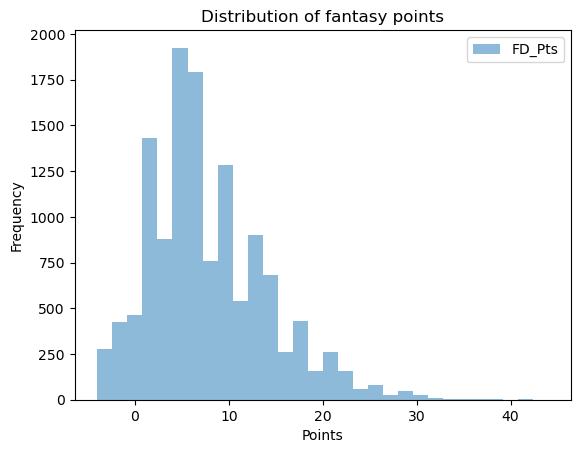

In [267]:
plt.hist(def_model['fantasy_points'], bins=30, alpha=0.5, label='FD_Pts')

# Adding titles and labels
plt.title('Distribution of fantasy points')
plt.xlabel('Points')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Show the plot
plt.show()

This is where we create that dataframe to derive fantasy points against opponents.

In [268]:
opp_vs_def = def_model[['season', 'week', 'game_id', 'opponent', 'fantasy_points']]

In [269]:
opp_vs_def = opp_vs_def.sort_values(by=['opponent', 'season', 'week', 'game_id'])

In [270]:
opp_vs_def['game_num'] = opp_vs_def.groupby(['opponent', 'season']).cumcount() + 1

In [271]:
opp_vs_def

,season,week,game_id,opponent,fantasy_points,game_num
1,2000,1,2000_01_ARI_NYG,ARI,10.0,1
39,2000,2,2000_02_DAL_ARI,ARI,9.0,2
93,2000,4,2000_04_GB_ARI,ARI,16.0,3
115,2000,5,2000_05_ARI_SF,ARI,5.0,4
145,2000,6,2000_06_CLE_ARI,ARI,4.0,5
...,...,...,...,...,...,...
12700,2023,13,2023_13_MIA_WAS,WAS,12.0,13
12766,2023,15,2023_15_WAS_LA,WAS,6.0,14
12798,2023,16,2023_16_WAS_NYJ,WAS,8.0,15
12828,2023,17,2023_17_SF_WAS,WAS,9.0,16


In [272]:
# Function to calculate equally weighted rolling mean
def calculate_equal_rolling_mean(group):
    # Calculate the equally weighted rolling mean of the last 8 games, excluding the current game
    group['rolling_mean_8'] = (
        group['fantasy_points'].shift().rolling(window=8, min_periods=1).mean()
    )
    return group

# Apply the rolling mean calculation using groupby
opp_vs_def = opp_vs_def.groupby('opponent', group_keys=False).apply(calculate_equal_rolling_mean)


In [273]:
# Linear and Exponential weights
# linear_weights = np.array([0.25, 0.20, 0.15, 0.13, 0.10, 0.08, 0.05, 0.04])
# exponential_weights = np.array([0.27, 0.23, 0.19, 0.15, 0.11, 0.09, 0.07, 0.05])

# Corrected Linear and Exponential weights
linear_weights = np.array([0.01, 0.03, 0.06, 0.10, 0.14, 0.18, 0.24, 0.28])
exponential_weights = np.array([0.015, 0.025, 0.04, 0.07, 0.10, 0.15, 0.25, 0.35])

In [274]:
# Function to calculate rolling means with different weights
def calculate_weighted_means(group):
    # Calculate the linear weighted rolling mean
    group['linear_rolling_mean_8'] = (
        group['fantasy_points'].shift().rolling(window=8, min_periods=1)
        .apply(lambda x: np.dot(x, linear_weights[-len(x):]), raw=False)
    )
    
    # Calculate the exponential weighted rolling mean
    group['exponential_rolling_mean_8'] = (
        group['fantasy_points'].shift().rolling(window=8, min_periods=1)
        .apply(lambda x: np.dot(x, exponential_weights[-len(x):]), raw=False)
    )
    return group

In [275]:
# Apply the calculations using groupby
opp_vs_def = opp_vs_def.groupby('opponent', group_keys=False).apply(calculate_weighted_means)

In [276]:
opp_vs_def.rename(columns = {'rolling_mean_8': 'opp_vs_def_L8',\
                             'linear_rolling_mean_8': 'opp_vs_def_L8_lin',\
                            'exponential_rolling_mean_8': 'opp_vs_def_L8_exp'}, inplace = True)

In [277]:
opp_vs_def.drop(columns = ['fantasy_points', 'game_num'], inplace = True)

In [278]:
opp_vs_def

,season,week,game_id,opponent,opp_vs_def_L8,opp_vs_def_L8_lin,opp_vs_def_L8_exp
1,2000,1,2000_01_ARI_NYG,ARI,NaN,NaN,NaN
39,2000,2,2000_02_DAL_ARI,ARI,10.000000,NaN,NaN
93,2000,4,2000_04_GB_ARI,ARI,9.500000,NaN,NaN
115,2000,5,2000_05_ARI_SF,ARI,11.666667,NaN,NaN
145,2000,6,2000_06_CLE_ARI,ARI,10.000000,NaN,NaN
...,...,...,...,...,...,...,...
12700,2023,13,2023_13_MIA_WAS,WAS,10.375000,13.31,13.875
12766,2023,15,2023_15_WAS_LA,WAS,10.625000,13.43,13.215
12798,2023,16,2023_16_WAS_NYJ,WAS,10.750000,11.84,10.730
12828,2023,17,2023_17_SF_WAS,WAS,10.000000,10.94,9.740


In [279]:
def_model = pd.merge(def_model, opp_vs_def, on = ['season', 'week', 'game_id', 'opponent'], how = 'left')

In [280]:
def_model.head()

,season,week,game_id,defteam,opponent,spread_line,total_line,outdoors,grass,home_team,fantasy_points,opp_vs_def_L8,opp_vs_def_L8_lin,opp_vs_def_L8_exp
0,2000,1,2000_01_ARI_NYG,ARI,NYG,-6.5,40.0,1,1,0,4.0,NaN,NaN,NaN
1,2000,1,2000_01_ARI_NYG,NYG,ARI,6.5,40.0,1,1,1,10.0,NaN,NaN,NaN
2,2000,1,2000_01_BAL_PIT,BAL,PIT,2.5,37.0,1,0,0,13.0,NaN,NaN,NaN
3,2000,1,2000_01_BAL_PIT,PIT,BAL,-2.5,37.0,1,0,1,2.0,NaN,NaN,NaN
4,2000,1,2000_01_CAR_WAS,CAR,WAS,-10.5,47.5,1,1,0,7.0,NaN,NaN,NaN


In [281]:
def_model.drop(columns = ['opponent'], inplace = True)

In [282]:
def_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12890 entries, 0 to 12889
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season             12890 non-null  int64  
 1   week               12890 non-null  int64  
 2   game_id            12890 non-null  object 
 3   defteam            12890 non-null  object 
 4   spread_line        12890 non-null  float64
 5   total_line         12890 non-null  float64
 6   outdoors           12890 non-null  int32  
 7   grass              12890 non-null  int32  
 8   home_team          12890 non-null  int64  
 9   fantasy_points     12890 non-null  float64
 10  opp_vs_def_L8      12858 non-null  float64
 11  opp_vs_def_L8_lin  12634 non-null  float64
 12  opp_vs_def_L8_exp  12634 non-null  float64
dtypes: float64(6), int32(2), int64(3), object(2)
memory usage: 1.2+ MB


In [283]:
def_model.dropna(inplace = True)

In [284]:
def_model.set_index(['season', 'week', 'game_id', 'defteam'], inplace = True)

In [285]:
def_model.head()

spread_line  total_line  outdoors  grass  \
season week game_id         defteam                                             
2000   9    2000_09_CAR_ATL CAR              3.0        45.5         0      0   
            2000_09_CIN_CLE CIN              3.0        35.5         1      1   
            2000_09_JAX_DAL DAL              4.0        44.5         1      0   
            2000_09_KC_SEA  KC               4.0        43.0         1      0   
            2000_09_PHI_NYG NYG              3.5        37.0         1      1   

                                     home_team  fantasy_points  opp_vs_def_L8  \
season week game_id         defteam                                             
2000   9    2000_09_CAR_ATL CAR              0            11.0          12.25   
            2000_09_CIN_CLE CIN              0            13.0          11.00   
            2000_09_JAX_DAL DAL              1             2.0          12.00   
            2000_09_KC_SEA  KC               0            12.0          12.75   
            2000_09_PHI_NYG NYG              1            10.0           8.00   

                                     opp_vs_def_L8_lin  opp_vs_def_L8_exp  
season week game_id         defteam                                        
2000   9    2000_09_CAR_ATL CAR                  13.04             11.580  
            2000_09_CIN_CLE CIN                  14.68             14.740  
            2000_09_JAX_DAL DAL                  14.92             14.350  
            2000_09_KC_SEA  KC                   12.53             12.555  
            2000_09_PHI_NYG NYG                   8.02              7.490

# Exploratory Data Analysis
We have five features so let's do some EDA.<br>

Things make sense here. The spread is symmetrical. Minimum fantasy points is -4 because allowing points is the only way points can be deducted from a fantasy defense and both sides subtract four for allowing 35 points or more.<br>

First we'll import sklearn.

In [286]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
from sklearn.model_selection import train_test_split 
from sklearn import linear_model, preprocessing 

In [287]:
def_model.describe()

,spread_line,total_line,outdoors,grass,home_team,fantasy_points,opp_vs_def_L8,opp_vs_def_L8_lin,opp_vs_def_L8_exp
count,12634.000000,12634.000000,12634.000000,12634.000000,12634.000000,12634.000000,12634.000000,12634.000000,12634.000000
mean,-0.005699,43.635112,0.756609,0.570524,0.499683,7.711334,7.729871,8.032965,7.723007
std,6.389072,4.934458,0.429146,0.495021,0.500020,6.344523,2.848455,3.353193,3.429885
min,-27.000000,28.500000,0.000000,0.000000,0.000000,-4.000000,-1.000000,-1.890000,-2.335000
25%,-4.000000,40.500000,1.000000,0.000000,0.000000,3.000000,5.750000,5.632500,5.270000
50%,0.000000,43.500000,1.000000,1.000000,0.000000,7.000000,7.562500,7.790000,7.430000
75%,4.000000,47.000000,1.000000,1.000000,1.000000,11.000000,9.625000,10.120000,9.845000
max,27.000000,63.500000,1.000000,1.000000,1.000000,44.000000,18.250000,22.670000,24.045000


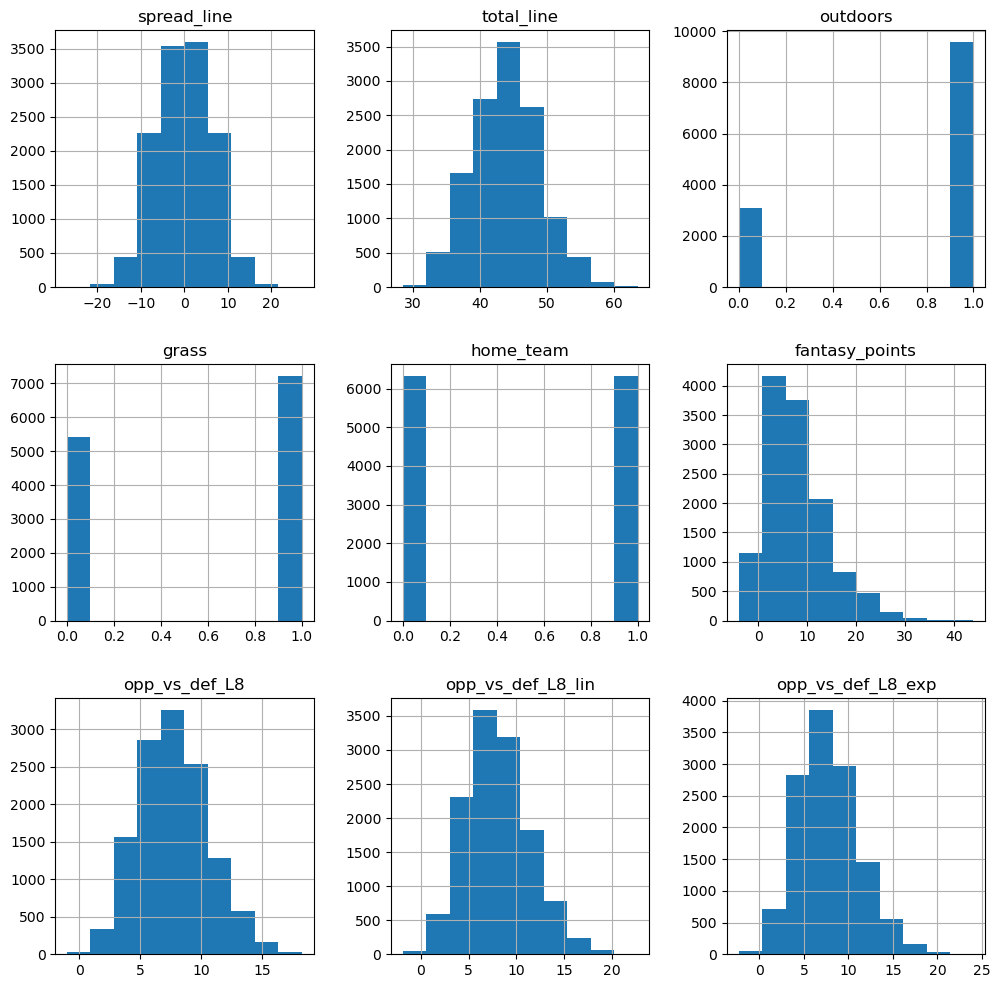

In [288]:
def_model.hist(layout = (3, 3), figsize = (12, 12))
#plt.subplots_adjust(hspace=1)
plt.show();

# High totals
We're checking over-unders higher than 60 to make sure there are no errors.<br>

This makes sense. Patrick Mahomes going up against a Rams team that made the Super Bowl that year. The Kurt Warner Rams in 2000. Drew Brees vs. Matt Ryan in the Superdome in 2018.

In [289]:
def_model[def_model['total_line'] > 60]

spread_line  total_line  outdoors  grass  \
season week game_id        defteam                                             
2000   9    2000_09_STL_SF LA               7.0        63.0         1      1   
2018   11   2018_11_KC_LA  KC              -3.0        63.5         1      1   
                           LA               3.0        63.5         1      1   
       12   2018_12_ATL_NO ATL            -11.5        61.0         0      0   
                           NO              11.5        61.0         0      0   

                                    home_team  fantasy_points  opp_vs_def_L8  \
season week game_id        defteam                                             
2000   9    2000_09_STL_SF LA               0             2.0          4.500   
2018   11   2018_11_KC_LA  KC               0            11.0          0.875   
                           LA               1            21.0          1.500   
       12   2018_12_ATL_NO ATL              0             3.0         -1.000   
                           NO               1            15.0          4.375   

                                    opp_vs_def_L8_lin  opp_vs_def_L8_exp  
season week game_id        defteam                                        
2000   9    2000_09_STL_SF LA                    5.85              6.575  
2018   11   2018_11_KC_LA  KC                    0.30             -0.160  
                           LA                    2.25              2.395  
       12   2018_12_ATL_NO ATL                  -1.89             -2.335  
                           NO                    5.06              5.020

In [290]:
def_model.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12634 entries, (2000, 9, '2000_09_CAR_ATL', 'CAR') to (2023, 22, '2023_22_SF_KC', 'SF')
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   spread_line        12634 non-null  float64
 1   total_line         12634 non-null  float64
 2   outdoors           12634 non-null  int32  
 3   grass              12634 non-null  int32  
 4   home_team          12634 non-null  int64  
 5   fantasy_points     12634 non-null  float64
 6   opp_vs_def_L8      12634 non-null  float64
 7   opp_vs_def_L8_lin  12634 non-null  float64
 8   opp_vs_def_L8_exp  12634 non-null  float64
dtypes: float64(6), int32(2), int64(1)
memory usage: 1.1+ MB


In [291]:
corr_df = def_model.corr()

In [292]:
corr_df['fantasy_points'].sort_values(ascending = False)

fantasy_points       1.000000
spread_line          0.241202
opp_vs_def_L8        0.189576
opp_vs_def_L8_lin    0.170907
opp_vs_def_L8_exp    0.159548
home_team            0.074004
outdoors             0.042573
grass                0.027881
total_line          -0.160199
Name: fantasy_points, dtype: float64

# No strong correlations
Before we aded the opp_vs_def features, spread_line had the strongest correlation and and total_line was second. Now two of the three features we've added are stronger than total_line, and one is pretty close. We realize that none of these correlations are particularly strong, but this seems to happen when using machine learning to predict sports.

# Putting 2023 aside
Before we start modeling, let's put 2023 aside because we might want to use it to run tests to make sure we can use this live. We'll rename def_model main_df so that we still have the 2023 data.

In [293]:
main_df = def_model.loc[def_model.index.get_level_values('season') != 2023]

In [294]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12064 entries, (2000, 9, '2000_09_CAR_ATL', 'CAR') to (2022, 22, '2022_22_KC_PHI', 'PHI')
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   spread_line        12064 non-null  float64
 1   total_line         12064 non-null  float64
 2   outdoors           12064 non-null  int32  
 3   grass              12064 non-null  int32  
 4   home_team          12064 non-null  int64  
 5   fantasy_points     12064 non-null  float64
 6   opp_vs_def_L8      12064 non-null  float64
 7   opp_vs_def_L8_lin  12064 non-null  float64
 8   opp_vs_def_L8_exp  12064 non-null  float64
dtypes: float64(6), int32(2), int64(1)
memory usage: 1.1+ MB


# Model preprocessing
* We split the dataset into a features (X) and target (y).<br>
* We split into train and test sets.<br>
* We scale the features.<br>
* We predict the target variable using Linear Regression.<br>

In [296]:
X = main_df[['spread_line', 'home_team', 'outdoors', 'grass', 'total_line', 'opp_vs_def_L8', 'opp_vs_def_L8_lin', 'opp_vs_def_L8_exp']]

In [297]:
y = main_df[['fantasy_points']]

In [298]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 43)

In [299]:
from sklearn.preprocessing import StandardScaler

In [300]:
scaler = StandardScaler()

In [301]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [302]:
X_scaled_df = pd.DataFrame(X_train_scaled, columns = X.columns)

In [303]:
X_scaled_df.mean()

spread_line          3.239684e-17
home_team            2.135247e-17
outdoors            -1.322170e-16
grass               -7.489141e-17
total_line           5.427523e-16
opp_vs_def_L8        3.954939e-17
opp_vs_def_L8_lin    2.781080e-16
opp_vs_def_L8_exp    2.436074e-16
dtype: float64

In [304]:
X_scaled_df.std()

spread_line          1.000059
home_team            1.000059
outdoors             1.000059
grass                1.000059
total_line           1.000059
opp_vs_def_L8        1.000059
opp_vs_def_L8_lin    1.000059
opp_vs_def_L8_exp    1.000059
dtype: float64

In [305]:
from sklearn.linear_model import LinearRegression

In [306]:
from sklearn.metrics import mean_absolute_error

In [307]:
base_LR = LinearRegression()

In [308]:
base_LR.fit(X_train_scaled, y_train)

LinearRegression()

In [309]:
base_LR_pred = base_LR.predict(X_test_scaled)

In [310]:
print(f"R_squared_train: {base_LR.score(X_train_scaled, y_train)}")
print(f"R_squared_test: {base_LR.score(X_test_scaled, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, base_LR_pred)}")
print(f"MSE: {mean_squared_error(y_test, base_LR_pred)}")
print(f"RMSE: {mean_squared_error(y_test, base_LR_pred, squared = False)}")

R_squared_train: 0.08508740793948633
R_squared_test: 0.09106536312480229
MAE: 4.682865052850021
MSE: 36.19395249834431
RMSE: 6.016140997212774


# Basic Linear Regression it is
We're going to stick with out-of-the-box Linear Regression to predict fantasy points for defenses.<br>

The mean absolute error is 4.6829. The explained variance is pretty similar between the training and test set. We tried Ridge Regularization and the best MAE we got was 4.7589. We tried Random Forest (code is commented out below), and the MAE was 4.8738. Random Forest saw some patterns in the training data but didn't generalize well with the test data. The R-squared was .8608 for the training data but .0191 for the test data.<br>

So Linear Regression takes a general look at the data and comes up with a prediction that might not be precise but is in the ballpark a lot of the time. As we've said before, this is the first of four (or possibly five) models that we need for this project. When it comes to defense in daily fantasy football, the philosophy is to find the cheapest tolerable defense, maybe an underdog home team, and spend most of your time on the other positions.<br>

We need to move on to creating models for quarterbacks and the other position players.

In [311]:
# from sklearn.linear_model import Ridge
# from sklearn.model_selection import GridSearchCV

In [312]:
# alpha_values = np.linspace(0.1, 100, 10)

In [313]:
# alpha_values = list(alpha_values)

In [314]:
# param_grid = {'alpha': alpha_values}
# Ridge_LR = Ridge()
# Ridge_CV = GridSearchCV(Ridge_LR, param_grid, cv = 5, scoring = 'neg_mean_absolute_error')
# Ridge_CV.fit(X_train_scaled, y_train)
# print(f"Ridge_model best params: {Ridge_CV.best_params_}")
# print(f"Ridge_model best score: {-Ridge_CV.best_score_}")

Ridge_model best params: {'alpha': 44.50000000000001}
Ridge_model best score: 4.758948756829265


In [315]:
# from sklearn.ensemble import RandomForestRegressor

In [320]:
# base_RF = RandomForestRegressor(random_state = 43)

In [321]:
# base_RF.fit(X_train_scaled, y_train)

C:\Users\Owner\anaconda3\envs\nfl_dfs_model\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=43)

In [322]:
# base_RF_pred = base_RF.predict(X_test_scaled)

In [323]:
print(f"R_squared_train: {base_RF.score(X_train_scaled, y_train)}")
print(f"R_squared_test: {base_RF.score(X_test_scaled, y_test)}")
print(f"MAE: {mean_absolute_error(y_test, base_RF_pred)}")
print(f"MSE: {mean_squared_error(y_test, base_RF_pred)}")
print(f"RMSE: {mean_squared_error(y_test, base_RF_pred, squared = False)}")

R_squared_train: 0.8607582090609264
R_squared_test: 0.01910866412282619
MAE: 4.873790055248619
MSE: 39.05928212707182
RMSE: 6.249742564863918
